In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ResNet import Bottleneck, ResNet, ResNet50

Data Augmentation： 
- clip
- padding to 40x40, then crop to 32x32
- normalize: x_norm = (x - 0.5) / 0.5 = 2x - 1 | [0,1]->[-1,1]

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [6]:
data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(data_train, batch_size=128, shuffle=True, num_workers=2)

data_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(data_test, batch_size=128,shuffle=False, num_workers=2)

View the picture after data-augmentation

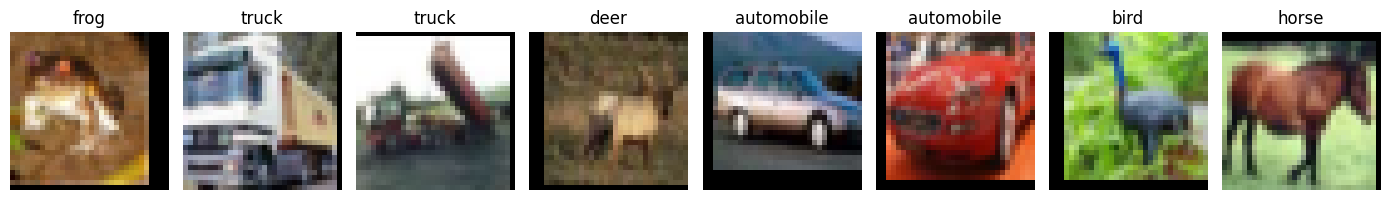

In [5]:
from matplotlib import pyplot as plt

def denormalize(img):
    img = img * 0.5 + 0.5
    return img

fig, axes = plt.subplots(1, 8, figsize=(14, 2))
for i in range(8):
    img, label = data_train[i]
    img = denormalize(img)
    img = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(data_train.classes[label])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
net = ResNet50(10).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [ ]:
EPOCHS = 200
avg_losses = []
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp # inputs: (b, 3, 32, 32), labels: (b)
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
    
        outputs = net(inputs) # (b, 10)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i%100 == 0 and i > 0:
            print(f'[epoch {epoch+1}, minibatch {i}]: Loss {running_loss / 100}')
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    avg_losses.append(avg_loss)
    scheduler.step(avg_loss)
            
print('Training Done')

[epoch 1, minibatch 100]: Loss 7.5935063815116886
[epoch 1, minibatch 200]: Loss 3.0510908913612367
[epoch 1, minibatch 300]: Loss 2.410805733203888
[epoch 2, minibatch 100]: Loss 2.163378837108612
[epoch 2, minibatch 200]: Loss 2.097980033159256
[epoch 2, minibatch 300]: Loss 2.0771222257614137
[epoch 3, minibatch 100]: Loss 2.0576286935806274
[epoch 3, minibatch 200]: Loss 2.015700663328171
[epoch 3, minibatch 300]: Loss 1.9823382675647736
[epoch 4, minibatch 100]: Loss 1.9881975972652435
[epoch 4, minibatch 200]: Loss 1.9346482276916503
[epoch 4, minibatch 300]: Loss 1.9343404591083526
[epoch 5, minibatch 100]: Loss 1.934804426431656
[epoch 5, minibatch 200]: Loss 1.8929119098186493
[epoch 5, minibatch 300]: Loss 1.8881633222103118
[epoch 6, minibatch 100]: Loss 1.893965047597885
[epoch 6, minibatch 200]: Loss 1.8593393802642821
[epoch 6, minibatch 300]: Loss 1.8491597819328307
[epoch 7, minibatch 100]: Loss 1.8385806488990784
[epoch 7, minibatch 200]: Loss 1.8179328548908233
[epoch

In [10]:
import os
os.makedirs('checkpoints', exist_ok=True)

# Save the model
torch.save(net.state_dict(), 'checkpoints/resnet50_cifar10.pth')
print('Model Saved')

Model Saved


In [ ]:
# Plot the training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS + 1), avg_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()
plt.savefig('checkpoints/loss_curve.png')  
plt.show()

In [10]:
correct = 0
total = 0
net = ResNet50(10).to('cuda')
net.load_state_dict(torch.load('checkpoints/resnet50_cifar10.pth'))
net.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)
        
        _, predicted = torch.max(outputs, 1) # (b,)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on 10,000 test images: ', 100*(correct/total), '%')

Accuracy on 10,000 test images:  87.88 %
